In [45]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import networkx as nx
import pylab as pl
%matplotlib inline
import scipy as sp
import scipy.sparse as sps
from sklearn.cluster import KMeans
from sklearn.cross_validation import KFold
from sklearn.multiclass import OneVsOneClassifier
from sklearn.svm import LinearSVC

In [2]:
def generateTwoGaussian():
    mean1 = [-2, -2]
    cov1 = [[1, 0], [0, 1]]  # diagonal covariance
    mean2 = [2,2]
    cov2 = [[1, 0], [0, 1]]  # diagonal covariance

    # data
    X = np.zeros((200,2))
    y = np.zeros(200,dtype=int)
    X[:100] = np.random.multivariate_normal(mean1, cov1, 100)
    X[100:] = np.random.multivariate_normal(mean2, cov2, 100)
    y[100:] = np.ones(100)
    return X,y,"Gaussian"

def generateXOR():
    mean1 = [-2, -2]
    cov1 = [[1, 0], [0, 1]]  # diagonal covariance
    mean2 = [2,2]
    cov2 = [[1, 0], [0, 1]]  # diagonal covariance

    # data
    X = np.zeros((400,2))
    y = np.zeros(400,dtype=int)
    X[:100] = np.random.multivariate_normal(mean1, cov1, 100)
    X[100:200] = np.random.multivariate_normal(mean2, cov2, 100)
    
    
    mean3 = [2, -2]
    cov3 = [[1, 0], [0, 1]]  # diagonal covariance
    mean4 = [-2, 2]
    cov4 = [[1, 0], [0, 1]]  # diagonal covariance

    X[200:300] = np.random.multivariate_normal(mean3, cov3, 100)
    X[300:] = np.random.multivariate_normal(mean4, cov4, 100)
    y[200:] = np.ones(200)
    
    return X,y,"XOR"

def generateTwoParabola():
    x1 = np.linspace(-10, 10, 40)
    y1 = .22*x1**2 + .024*x1 + .04  

    x2 = np.linspace(0, 20, 40)
    y2 = -.2*(x2-10)**2 - .024*(x2-10) + 35

    size = x1.shape[0]
    EACH = 10
    X = np.zeros((2*size*EACH,2))
    y = np.zeros(2*size*EACH,dtype=int)
    y[size*EACH:] = np.ones(size*EACH)

    cov = [[1, 0], [0, 1]]  # diagonal covariance
    for i in range(size):
        X[i*EACH:(i+1)*EACH] = np.random.multivariate_normal([x1[i],y1[i]], cov, EACH)
        X[(i+size)*EACH:(i+size+1)*EACH] = np.random.multivariate_normal([x2[i],y2[i]], cov, EACH)
    return X,y,"Parabolas"

In [3]:
colors = ['b', 'g', 'r', 'c', 'm', 'y', 'k', 'w']
def plotData(X,y,dataName):
    num = len(np.unique(sorted(y)))
    for i in range(num):
        plt.plot(X[:,0][y==i], X[:,1][y==i], colors[i%8]+'o')
    plt.axis('equal')
#     plt.savefig(dataName+'.jpg')
    plt.show()




def Prototyping(X,numP):
    kmeans = KMeans(init='k-means++',n_clusters=numP)
    kmeans.fit(X)

    centers = kmeans.cluster_centers_
#     plotData(X,kmeans.labels_,"Two Gaussian")
    
    return centers
def distance2(p1,p2):
    ans = 0
    for i in xrange(p1.shape[0]):
        ans += (p1[i] - p2[i]) ** 2
    return ans
def similarity(p1,p2,sigma):
    return np.exp((-distance2(p1,p2))/(2*(sigma**2)))

In [4]:
def bipartiteUnsupervised(X,centers,sigma):
    numS = X.shape[0]
    numP = centers.shape[0]
#     print numS,numP
    N = numS + numP
    W = sps.lil_matrix((N,N))
    for i in xrange(numS):
        for j in xrange(numP):
            W[i,numS+j] = similarity(X[i],centers[j],sigma)
            W[numS+j,i] = W[i,numS+j]
    W = sps.csr_matrix(W)
    d = np.array(W.sum(axis=0))
    D = sps.diags(d,[0])
    L = D - W
    return W,D,L

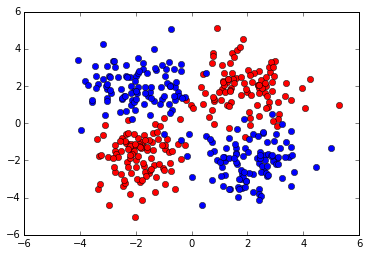

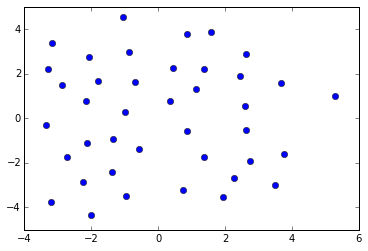

In [5]:
#supervisedBipartite10Fold
X,y,name = generateXOR()
plt.plot(X[:,0][y==0],X[:,1][y==0],'ro')
plt.plot(X[:,0][y==1],X[:,1][y==1],'bo')
plt.show()

numP = 40
centers = Prototyping(X,numP)
plt.plot(centers[:,0],centers[:,1],'bo')

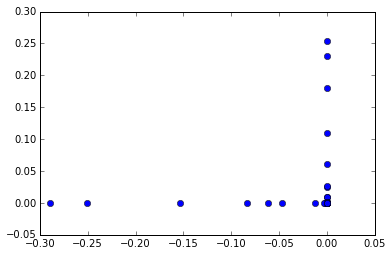

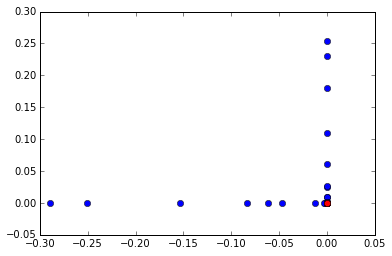

In [6]:
sigma = .1
numS = X.shape[0]

W,D,L = bipartiteUnsupervised(X,centers,sigma)
vals, vecs = sps.linalg.eigs(L, k=3)
vals = vals.real
vecs = vecs.real[:numS]
plt.plot(vecs[:,0][y==1],vecs[:,1][y==1],'ro')
plt.plot(vecs[:,0][y==0],vecs[:,1][y==0],'bo')
plt.show()
plt.plot(vecs[:,0][y==0],vecs[:,1][y==0],'bo')
plt.plot(vecs[:,0][y==1],vecs[:,1][y==1],'ro')
plt.show()

In [7]:

# sigma = 20

# for sigma in [.01,.02,.05,.1,.2,.5,1,2,5,10,15,20,25,30,35]:
#     print '=======================================================================',sigma
#     W,D,L = bipartiteUnsupervised(X,centers,sigma)
#     try:
#         vals, vecs = sps.linalg.eigs(L, M=D, k=7)
#         vals = vals.real
#         vecs = vecs.real[:numS]
#         for i in xrange(1,7,2):
#             print '------------------------------------------'+str(i),str(i+1)+'---------------'
#             plt.plot(vecs[:,i][y==1],vecs[:,i+1][y==1],'ro')
#             plt.plot(vecs[:,i][y==0],vecs[:,i+1][y==0],'bo')
#             plt.show()
#             plt.plot(vecs[:,i][y==0],vecs[:,i+1][y==0],'bo')
#             plt.plot(vecs[:,i][y==1],vecs[:,i+1][y==1],'ro')
#             plt.show()
#     except Exception as e:
#         print e

In [8]:
# from sklearn import neighbors
# kf = KFold(numS,n_folds=10,shuffle=True)

# Means = np.zeros(20)
# for sigma in xrange(1,20):
#     acc = []
#     for train_index,test_index in kf:
#         W,D,L = bipartiteUnsupervised(X,centers,sigma)
#         vals, vecs = sps.linalg.eigs(L, M=D, k=7)
#         vals = vals.real
#         vecs = vecs.real[:numS]
#         yTrain = y[train_index]
#         yTest = y[test_index]
#         newRepTrain = vecs[:,:6][train_index]
#         newRepTest = vecs[:,:6][test_index]
#         NN = neighbors.KNeighborsClassifier()
#         NN.fit(newRepTrain,yTrain)
#         XPred = NN.predict(newRepTest)
#         acc.append(np.sum(XPred==yTest)*1.0/yTest.shape[0])
#     print "sigma is:",sigma," ,accuracy:",acc
#     print "Mean:", np.mean(acc), "std:",np.std(acc)
#     Means[sigma-1] = np.mean(acc)

In [9]:
# print Means.shape
# plt.plot(range(1,20),Means[:19])
# plt.xlabel('sigma')
# plt.ylabel('accuracy')

In [10]:
# wine  -------------------------------------------------------------------------------------------------
def loadWine():
    wineData = pd.read_csv('data/wine.data',header=None)
    wineY = wineData[0].apply(lambda x: x-1).values
    wineX = wineData.drop(0,axis=1)
    wineX = wineX.values
    return wineX,wineY

# wine  -------------------------------------------------------------------------------------------------
def loadWineNorm():
    wineData = pd.read_csv('data/wine.data',header=None)
    wineY = wineData[0].apply(lambda x: x-1).values
    wineX = wineData.drop(0,axis=1)
    wineX = wineX.values
    wineX = (wineX - wineX.mean(axis=0))/(wineX.max(axis=0)-wineX.min(axis=0))
    return wineX,wineY

# glass  -------------------------------------------------------------------------------------------------
def loadGlass():
    glassData = pd.read_csv('data/glass.data',header=None)
    glassY = glassData[10].apply(lambda x: x-1 if x<4 else x-2).values
    glassX = glassData.drop([0,10],axis=1)
    glassX = glassX.values
    return glassX,glassY
    
# sonar  -------------------------------------------------------------------------------------------------
def loadSonar():
    sonarData = pd.read_csv('data/sonar.data',header=None)
    sonarY = (sonarData[60].apply(lambda x: 0 if x=='M' else 1)).values
    sonarX = sonarData.drop(60,axis=1)
    sonarX = sonarX.values
    return sonarX,sonarY

# iris  -------------------------------------------------------------------------------------------------
def irisLableSet(name):
    names = ['Iris-setosa', 'Iris-versicolor', 'Iris-virginica']
    for i in xrange(3):
        if names[i] == name:
            return i
def loadIris():
    irisData = pd.read_csv('data/iris.data',header=None)
    irisY = irisData[4].apply(irisLableSet).values
    irisX = irisData.drop(4,axis=1)
    irisX = irisX.values
    return irisX,irisY
    
# mnist   -------------------------------------------------------------------------------------------------
import scipy.io
def loadMnist():
    mnist = scipy.io.loadmat('data/mnistAll.mat')
    trains = []
    labels = []
    tests = []
    for i in range(10):
        trains.append(mnist['train'+str(i)])
        num = mnist['train'+str(i)].shape[0]
        labels.append(i*np.ones(num,dtype=int))
    mnistX = np.concatenate(trains)
    mnistY = np.concatenate(labels)
    return mnistX,mnistY
    
# breast cancer  -------------------------------------------------------------------------------------------------
def loadWdbc():
    wdbcData = pd.read_csv('data/wdbc.data',header=None)
    wdbcY = (wdbcData[1].apply(lambda x: 0 if x=='M' else 1)).values
    wdbcX = wdbcData.drop([0,1],axis=1)
    wdbcX = wdbcX.values
    return wdbcX,wdbcY

# usps   -------------------------------------------------------------------------------------------------
def loadUsps():
    with open('data/usps/usps_train.jf','r') as f:
        i = 0
        lines = f.readlines()
        uspsX = np.zeros((len(lines),256))
        uspsY = np.zeros(len(lines),dtype=int)
        for line in lines:
            splitedLine = line.split()
            features = map(float,splitedLine[1:])
            uspsY[i] = int(splitedLine[0])
            for j in xrange(256):
                uspsX[i,j] = features[j]
            i += 1
    return uspsX,uspsY

# waveform  -------------------------------------------------------------------------------------------------
def loadWaveform():
    waveformData = pd.read_csv('data/waveForm/waveform.data',header=None)
    waveformY = waveformData[21].values
    waveformX = waveformData.drop(21,axis=1)
    waveformX = waveformX.values
    return waveformX,waveformY   

In [11]:
from sklearn import neighbors
def unsupervised10Fold(X,y,numP,sigma):
#     numP = 40
    numS = X.shape[0]
    centers = Prototyping(X,numP)
    acc = []
    kf = KFold(numS,n_folds=10,shuffle=True)
    i = 0
    for train_index,test_index in kf:
        W,D,L = bipartiteUnsupervised(X,centers,sigma)
        vals, vecs = sps.linalg.eigs(L, M=D, k=7)
        vals = vals.real
        vecs = vecs.real[:numS]
        yTrain = y[train_index]
        yTest = y[test_index]
        newRepTrain = vecs[:,1:7][train_index]
        newRepTest = vecs[:,1:7][test_index]
        NN = neighbors.KNeighborsClassifier(n_neighbors=2)
        NN.fit(newRepTrain,yTrain)
        XPred = NN.predict(newRepTest)
        acc.append(np.sum(XPred==yTest)*1.0/yTest.shape[0])
#         print i,":",acc[i]
        i += 1
    return np.mean(acc),np.std(acc)

In [12]:
from sklearn.naive_bayes import GaussianNB
def unsupervised10FoldClf(X,y,numP,sigma,nclf):
#     numP = 40
    numS = X.shape[0]
    centers = Prototyping(X,numP)
    acc = []
    kf = KFold(numS,n_folds=10,shuffle=True)
    i = 0
    for train_index,test_index in kf:
        W,D,L = bipartiteUnsupervised(X,centers,sigma)
        vals, vecs = sps.linalg.eigs(L, M=D, k=7)
        vals = vals.real
        vecs = vecs.real[:numS]
        yTrain = y[train_index]
        yTest = y[test_index]
        newRepTrain = vecs[:,1:7][train_index]
        newRepTest = vecs[:,1:7][test_index]
#         NN = neighbors.KNeighborsClassifier(n_neighbors=2)
        nclf.fit(newRepTrain,yTrain)
        XPred = nclf.predict(newRepTest)
        acc.append(np.sum(XPred==yTest)*1.0/yTest.shape[0])
#         print i,":",acc[i]
        i += 1
    return np.mean(acc),np.std(acc)

In [46]:
# nclf = GaussianNB()
nclf = predict = OneVsOneClassifier(LinearSVC(random_state=0))
X,y,name = generateXOR()
for numP in xrange(10,41,10):
    print '-----------------------------------------------------numP:',numP
    t = unsupervised10FoldClf(X,y,numP,1,nclf)
    print "accuracy:",t
# supervised10FoldRepresentation(X,y,sigma)

-----------------------------------------------------numP: 10
accuracy: (0.94250000000000012, 0.037165171868296244)
-----------------------------------------------------numP: 20
accuracy: (0.96500000000000008, 0.029999999999999988)
-----------------------------------------------------numP: 30
accuracy: (0.95749999999999991, 0.022499999999999989)
-----------------------------------------------------numP: 40
accuracy: (0.95500000000000007, 0.038405728739343024)


In [47]:
def runP(X,Y):
    Means = np.zeros(20)
    for numP in xrange(20,61,5):
        print wineX.shape
        Means[numP/5-4] = unsupervised10Fold(X,Y,numP,2)
        # supervised10FoldRepresentation(wineX,wineY,1)
    return Means

def runSigma(X,Y,sigmas,nclf):
    Means = np.zeros(len(sigmas))
    Stds = np.zeros(len(sigmas))
    numP = 30
    idx = 0
    for sigma in sigmas:
#         print '--------------------------------------- sigma: ',sigma
        try:
            Means[idx],Stds[idx] = unsupervised10FoldClf(X,Y,numP,sigma,nclf)
        except Exception as e:
            print e
        idx += 1
#         Means[idx] = supervised10FoldRepresentation(wineX,wineY,1)
    return Means,Stds

In [48]:
def run10Fold(X,y,sigmas,nclf):
    result = []
    resultStd = []
    for i in xrange(10):
        Means,Stds = runSigma(X,y,sigmas,nclf)
        result.append(Means.max())
        resultStd.append(Stds[Means.argmax()])
        print i , Means.max(),Stds[Means.argmax()]
    return result,resultStd

In [76]:
# naiveBayes = GaussianNB()
from sklearn.svm import SVC
from sklearn.svm import LinearSVC
naiveBayes = OneVsOneClassifier(LinearSVC(C=1.0, class_weight=None, dual=True, fit_intercept=True))
sigmas = [10,15,20,25,30,35,40,45,50,55,60,65,70,75]
wineX,wineY = loadWineNorm()
wineResult,wineResultStd = run10Fold(wineX,wineY,sigmas,naiveBayes)

0 0.404575163399 0.111818203762
1 0.406209150327 0.140773829724
2 0.41568627451 0.168519750782
3 0.406535947712 0.176544404799
4 0.409477124183 0.167261848975
5 0.411111111111 0.137167728308
6 0.406862745098 0.177323345087
7 0.407189542484 0.188702216826
8 0.416666666667 0.201495169426
9 0.409150326797 0.124824623865


In [53]:
print wineResult
print wineResultStd

[0.39967320261437911, 0.40032679738562094, 0.39967320261437911, 0.4088235294117647, 0.40196078431372551, 0.40000000000000002, 0.40032679738562094, 0.40032679738562094, 0.40098039215686276, 0.40065359477124185]
[0.11778359905238436, 0.093526305881938443, 0.092824840089673968, 0.17350109932369293, 0.16488215487025931, 0.11200333810468861, 0.10484289665384514, 0.14632533125671923, 0.14328528174161723, 0.1347435990999129]


In [54]:
sigmas = [.001,.01,.02,.05,.1,.2,.3,.4,.5,.6,.7,.8,.9,1]
irisX,irisY = loadIris()
irisResult,irisResultStd = run10Fold(irisX,irisY,sigmas,naiveBayes)

Factor is exactly singular
Factor is exactly singular
ARPACK error -1: No convergence (1801 iterations, 3/7 eigenvectors converged)
ARPACK error -1: No convergence (1801 iterations, 2/7 eigenvectors converged)
0 0.88 0.157197681634
Factor is exactly singular
Factor is exactly singular
ARPACK error -1: No convergence (1801 iterations, 0/7 eigenvectors converged) [ARPACK error -14: DNAUPD  did not find any eigenvalues to sufficient accuracy.]
ARPACK error -1: No convergence (1801 iterations, 0/7 eigenvectors converged) [ARPACK error -14: DNAUPD  did not find any eigenvalues to sufficient accuracy.]
1 0.92 0.102415276638
Factor is exactly singular
Factor is exactly singular
ARPACK error -1: No convergence (1801 iterations, 0/7 eigenvectors converged) [ARPACK error -14: DNAUPD  did not find any eigenvalues to sufficient accuracy.]
ARPACK error -1: No convergence (1801 iterations, 2/7 eigenvectors converged)
2 0.906666666667 0.0611010092661
Factor is exactly singular
Factor is exactly singu

In [55]:
irisResult,irisResultStd

([0.87999999999999989,
  0.91999999999999993,
  0.90666666666666684,
  0.93333333333333335,
  0.94666666666666666,
  0.91333333333333333,
  0.94666666666666666,
  0.95333333333333337,
  0.94666666666666666,
  0.85333333333333328],
 [0.15719768163402129,
  0.10241527663824812,
  0.061101009266077852,
  0.051639777949432211,
  0.058118652580542308,
  0.1765093639316497,
  0.058118652580542302,
  0.052068331172711015,
  0.04988876515698587,
  0.20827332469084414])

In [56]:
sigmas = [.5,.8,1,2,3,4,5,8,10,15,20,25,30,35]
glassX,glassY = loadGlass()
glassResult,glassResultStd = run10Fold(glassX,glassY,sigmas,naiveBayes)

ARPACK error -1: No convergence (2441 iterations, 0/7 eigenvectors converged) [ARPACK error -14: DNAUPD  did not find any eigenvalues to sufficient accuracy.]
0 0.355627705628 0.0749996095765
ARPACK error -1: No convergence (2441 iterations, 0/7 eigenvectors converged) [ARPACK error -14: DNAUPD  did not find any eigenvalues to sufficient accuracy.]
1 0.355194805195 0.0810429037595
ARPACK error -1: No convergence (2441 iterations, 0/7 eigenvectors converged) [ARPACK error -14: DNAUPD  did not find any eigenvalues to sufficient accuracy.]
2 0.355194805195 0.0755063862865
ARPACK error -1: No convergence (2441 iterations, 0/7 eigenvectors converged) [ARPACK error -14: DNAUPD  did not find any eigenvalues to sufficient accuracy.]
3 0.356277056277 0.0908637281174
ARPACK error -1: No convergence (2441 iterations, 0/7 eigenvectors converged) [ARPACK error -14: DNAUPD  did not find any eigenvalues to sufficient accuracy.]
4 0.356277056277 0.0978594385143
ARPACK error -1: No convergence (2441 it

In [57]:
glassResult,glassResultStd

([0.35562770562770563,
  0.35519480519480517,
  0.35519480519480517,
  0.3562770562770563,
  0.35627705627705625,
  0.35584415584415585,
  0.35584415584415585,
  0.35649350649350647,
  0.35584415584415591,
  0.35606060606060608],
 [0.074999609576515441,
  0.081042903759492912,
  0.075506386286495919,
  0.090863728117362222,
  0.097859438514329503,
  0.08594027665748416,
  0.080989412091786298,
  0.085884925689180422,
  0.10633060429666293,
  0.088465668747564272])

In [58]:
sigmas = [10,11,12,15,20,21,22,23,24,25,26,27,28,29,30,35]
wdbcX,wdbcY = loadWdbc()
wdbcResult,wdbcResultStd = run10Fold(wdbcX,wdbcY,sigmas,naiveBayes)

ARPACK error -1: No convergence (5991 iterations, 6/7 eigenvectors converged)
ARPACK error -1: No convergence (5991 iterations, 3/7 eigenvectors converged)
ARPACK error -1: No convergence (5991 iterations, 0/7 eigenvectors converged) [ARPACK error -14: DNAUPD  did not find any eigenvalues to sufficient accuracy.]
ARPACK error -1: No convergence (5991 iterations, 0/7 eigenvectors converged) [ARPACK error -14: DNAUPD  did not find any eigenvalues to sufficient accuracy.]
ARPACK error -1: No convergence (5991 iterations, 0/7 eigenvectors converged) [ARPACK error -14: DNAUPD  did not find any eigenvalues to sufficient accuracy.]
ARPACK error -1: No convergence (5991 iterations, 6/7 eigenvectors converged)
ARPACK error -1: No convergence (5991 iterations, 5/7 eigenvectors converged)
ARPACK error -1: No convergence (5991 iterations, 6/7 eigenvectors converged)
ARPACK error -1: No convergence (5991 iterations, 6/7 eigenvectors converged)
0 0.854010025063 0.0469857973526
ARPACK error -1: No co

In [59]:
wdbcResult,wdbcResultStd

([0.85401002506265677,
  0.79270050125313285,
  0.78204887218045116,
  0.7767230576441102,
  0.79799498746867159,
  0.78546365914786964,
  0.81726190476190474,
  0.7734649122807018,
  0.82951127819548875,
  0.7923558897243107],
 [0.046985797352573244,
  0.043937911288878362,
  0.053423018056225687,
  0.070043014432326814,
  0.060142021140734407,
  0.051402280674864236,
  0.057647864444058838,
  0.066444473331638845,
  0.0294798666431112,
  0.061671579943398516])

In [60]:
sigmas = [1,2,5,10,15,20,24,30,35]
uspsX,uspsY = loadUsps()
uspsResult,uspsResultStd = run10Fold(uspsX,uspsY,sigmas,naiveBayes)
# uspsResultStd = [0.0138733106762,.0125098424437,
#          0.0156577174213, 0.0157205293285,
#          0.0098564763582, 0.0135094105704,
#          0.00913332458321,0.0142158233636,
#          0.0138485312521]
    
# uspsResult = [0.840759907548,0.849678110378,
#             0.837880188662,0.840900088318,
#             0.841448409343,0.840213089802,
#             0.841448973073,0.84185542214, 
#             0.841450100532]

ARPACK error -1: No convergence (73211 iterations, 6/7 eigenvectors converged)
0 0.659032452036 0.015284052802
1 0.680839393427 0.00985365604068
2 0.767655448447 0.013549625639
3 0.738444857846 0.0142124559428
4 0.741598549336 0.0126183953239
5 0.690029689761 0.0196160356474
6 0.716635661537 0.0272493178151
ARPACK error -1: No convergence (73211 iterations, 0/7 eigenvectors converged) [ARPACK error -14: DNAUPD  did not find any eigenvalues to sufficient accuracy.]
7 0.65409511998 0.0191337751927
8 0.745573406994 0.0402287843171
9 0.748181971926 0.0157016846753


In [61]:
uspsResult,uspsResultStd

([0.65903245203600347,
  0.68083939342691235,
  0.7676554484469249,
  0.73844485784617697,
  0.74159854933573865,
  0.69002968976079071,
  0.71663566153672698,
  0.65409511998045744,
  0.74557340699400565,
  0.74818197192626412],
 [0.015284052802049898,
  0.0098536560406799339,
  0.013549625638954819,
  0.014212455942833919,
  0.012618395323896062,
  0.019616035647391804,
  0.027249317815117875,
  0.019133775192711935,
  0.040228784317073607,
  0.015701684675342706])

In [62]:
sigmas = [.2,.5,.6,.7,.8,.9,1,1.1,1.2,1.5,2,2.5,3,4,5,7,8,10]
waveformX,waveformY= loadWaveform()
waveformResult,waveformResultStd = run10Fold(waveformX,waveformY,sigmas,naiveBayes)

ARPACK error -1: No convergence (50301 iterations, 3/7 eigenvectors converged)
0 0.8408 0.0151578362572
ARPACK error -1: No convergence (50301 iterations, 3/7 eigenvectors converged)
1 0.8416 0.0192623986045
ARPACK error -1: No convergence (50301 iterations, 4/7 eigenvectors converged)
2 0.841 0.0120415945788
ARPACK error -1: No convergence (50301 iterations, 4/7 eigenvectors converged)
3 0.833 0.0148391374412
ARPACK error -1: No convergence (50301 iterations, 6/7 eigenvectors converged)
4 0.8402 0.0159110024826
ARPACK error -1: No convergence (50301 iterations, 1/7 eigenvectors converged)
5 0.8438 0.0155293270942
ARPACK error -1: No convergence (50301 iterations, 4/7 eigenvectors converged)
6 0.8338 0.0190042100599
ARPACK error -1: No convergence (50301 iterations, 1/7 eigenvectors converged)
7 0.8292 0.0162037032804
ARPACK error -1: No convergence (50301 iterations, 2/7 eigenvectors converged)
8 0.8384 0.0120266371027
ARPACK error -1: No convergence (50301 iterations, 6/7 eigenvector

In [63]:
waveformResult,waveformResultStd

([0.84079999999999999,
  0.84160000000000001,
  0.84099999999999997,
  0.83299999999999996,
  0.84019999999999995,
  0.84379999999999988,
  0.8338000000000001,
  0.82919999999999994,
  0.83840000000000003,
  0.83679999999999988],
 [0.015157836257197146,
  0.019262398604535227,
  0.012041594578792305,
  0.014839137441239613,
  0.015911002482559031,
  0.015529327094243343,
  0.019004210059878839,
  0.016203703280423257,
  0.012026637102698337,
  0.0081584312217484623])

In [64]:
sigmas = [2,3,4,4.1,4.2,4.5,4.8,5,5.1,5.2,5.5,5.8,6,7,8,10]
sonarX,sonarY= loadSonar()
sonarResult,sonarResultStd = run10Fold(sonarX,sonarY,sigmas,naiveBayes)

0 0.534047619048 0.113499528004
1 0.534761904762 0.0807012912703
2 0.535 0.13141498377
3 0.535 0.12791742837
4 0.535476190476 0.132695968118
5 0.534523809524 0.122619047619
6 0.535 0.110820737354
7 0.534523809524 0.127363149624
8 0.534047619048 0.0617401657964
9 0.535 0.116048166167


In [65]:
sonarResult,sonarResultStd

([0.5340476190476191,
  0.53476190476190477,
  0.53500000000000003,
  0.53500000000000003,
  0.53547619047619044,
  0.53452380952380951,
  0.53500000000000003,
  0.53452380952380951,
  0.53404761904761899,
  0.53499999999999992],
 [0.11349952800405322,
  0.080701291270328573,
  0.13141498376967398,
  0.12791742836973241,
  0.13269596811752996,
  0.12261904761904763,
  0.11082073735391043,
  0.12736314962376744,
  0.061740165796362739,
  0.11604816616710625])

In [66]:
sigmas = [1,2,5,10,15,20,24,30,35]
moonX,moonY, tmp = generateTwoParabola()
moonResult,moonResultStd = run10Fold(moonX,moonY,sigmas,naiveBayes)

0 0.525 0.159589316685
1 0.5075 0.148660687473
2 0.5425 0.180034718874
3 0.56 0.222682509416
4 0.55125 0.198624174007
5 0.5575 0.190574788469
6 0.5925 0.207228738355
7 0.605 0.259639172699
8 0.6075 0.208806130178
9 0.6275 0.229115145724


In [67]:
moonResult,moonResultStd

([0.52500000000000002,
  0.50750000000000006,
  0.54249999999999998,
  0.55999999999999994,
  0.55124999999999991,
  0.55749999999999988,
  0.59250000000000003,
  0.60499999999999998,
  0.60749999999999993,
  0.62750000000000006],
 [0.15958931668504631,
  0.14866068747318503,
  0.18003471887388831,
  0.2226825094164335,
  0.19862417400709309,
  0.19057478846898926,
  0.20722873835450528,
  0.25963917269934444,
  0.20880613017821101,
  0.22911514572371683])

In [68]:
def generateTwoDisks():
    angle = np.arange(0, np.pi*2, 0.15)

    r1 = 50
    r2 = 20
    size = angle.shape[0]

    x1 = r1 * np.cos(angle)
    y1 = r1 * np.sin(angle)

    x2 = r2 * np.cos(angle)
    y2 = r2 * np.sin(angle)


    EACH = 10
    X = np.zeros((2*size*EACH,2))
    Y = np.zeros(2*size*EACH)
    Y[size*EACH:] = np.ones(size*EACH)

    cov = [[5, 0], [0, 5]]  # diagonal covariance
    for i in range(size):
        X[i*EACH:(i+1)*EACH] = np.random.multivariate_normal([x1[i],y1[i]], cov, EACH)
        X[(i+size)*EACH:(i+size+1)*EACH] = np.random.multivariate_normal([x2[i],y2[i]], cov, EACH)
    return X,Y,"Disks"

In [69]:
sigmas = [1,2,5,10,15,20,24,30,35]
diskX,diskY,tmp = generateTwoDisks()
diskResult,diskResultStd = run10Fold(diskX,diskY,sigmas,naiveBayes)

0 1.0 0.0
ARPACK error -1: No convergence (8701 iterations, 6/7 eigenvectors converged)
1 0.942857142857 0.171428571429
ARPACK error -1: No convergence (8701 iterations, 0/7 eigenvectors converged) [ARPACK error -14: DNAUPD  did not find any eigenvalues to sufficient accuracy.]
2 0.757142857143 0.0994884876942
ARPACK error -1: No convergence (8701 iterations, 0/7 eigenvectors converged) [ARPACK error -14: DNAUPD  did not find any eigenvalues to sufficient accuracy.]
3 0.684523809524 0.0835456479025
ARPACK error -1: No convergence (8701 iterations, 0/7 eigenvectors converged) [ARPACK error -14: DNAUPD  did not find any eigenvalues to sufficient accuracy.]
4 0.747619047619 0.0918751494361
ARPACK error -1: No convergence (8701 iterations, 6/7 eigenvectors converged)
5 1.0 0.0
ARPACK error -1: No convergence (8701 iterations, 5/7 eigenvectors converged)
6 0.930952380952 0.168089167569
ARPACK error -1: No convergence (8701 iterations, 6/7 eigenvectors converged)
7 1.0 0.0
ARPACK error -1: N

In [70]:
diskResult,diskResultStd

([1.0,
  0.94285714285714284,
  0.75714285714285712,
  0.68452380952380953,
  0.74761904761904763,
  1.0,
  0.93095238095238098,
  1.0,
  1.0,
  0.6261904761904763],
 [0.0,
  0.17142857142857143,
  0.099488487694172276,
  0.083545647902489278,
  0.091875149436070169,
  0.0,
  0.16808916756878847,
  0.0,
  0.0,
  0.24526121019127708])

In [71]:
sigmas = [0.01,.02,.05,.1,.2,.5,1,2,5]
xorX,xorY,tmp = generateXOR()
xorResult,xorResultStd = run10Fold(xorX,xorY,sigmas,naiveBayes)

Factor is exactly singular
Factor is exactly singular
ARPACK error -1: No convergence (4301 iterations, 0/7 eigenvectors converged) [ARPACK error -14: DNAUPD  did not find any eigenvalues to sufficient accuracy.]
0 0.8525 0.128671092325
Factor is exactly singular
Factor is exactly singular
Factor is exactly singular
ARPACK error -1: No convergence (4301 iterations, 0/7 eigenvectors converged) [ARPACK error -14: DNAUPD  did not find any eigenvalues to sufficient accuracy.]
1 0.74 0.24269322199
Factor is exactly singular
Factor is exactly singular
Factor is exactly singular
ARPACK error -1: No convergence (4301 iterations, 0/7 eigenvectors converged) [ARPACK error -14: DNAUPD  did not find any eigenvalues to sufficient accuracy.]
2 0.885 0.0691013748054
Factor is exactly singular
Factor is exactly singular
ARPACK error -1: No convergence (4301 iterations, 0/7 eigenvectors converged) [ARPACK error -14: DNAUPD  did not find any eigenvalues to sufficient accuracy.]
3 0.765 0.0916515138991
F

In [72]:
xorResult,xorResultStd

([0.85250000000000004,
  0.73999999999999999,
  0.88500000000000001,
  0.76500000000000001,
  0.89000000000000001,
  0.94750000000000001,
  0.755,
  0.90999999999999992,
  0.78999999999999992,
  0.78500000000000003],
 [0.12867109232457771,
  0.24269322199023197,
  0.069101374805426261,
  0.091651513899116813,
  0.089582364335844558,
  0.017499999999999974,
  0.13171939872319491,
  0.088881944173155869,
  0.10198039027185571,
  0.10074720839804943])

In [73]:
import scipy.io as io
def generateConcentric():
    concentric = io.loadmat("Concentric_rings.mat")
    X = concentric['X'][:,[0,1]]
    Y = concentric['Y'][:,0]
    Y = (Y==1)
    return X,Y,"Concentric"

In [74]:
sigmas = [0.01,.02,.05,.1,.2,.5,1,2,5,10]
concentricX,concentricY,tmp = generateConcentric()
concentricResult,concentricResultStd = run10Fold(concentricX,concentricY,sigmas,naiveBayes)

Factor is exactly singular
ARPACK error -1: No convergence (3431 iterations, 0/7 eigenvectors converged) [ARPACK error -14: DNAUPD  did not find any eigenvalues to sufficient accuracy.]
0 0.882056451613 0.0583912179975
Factor is exactly singular
ARPACK error -1: No convergence (3431 iterations, 0/7 eigenvectors converged) [ARPACK error -14: DNAUPD  did not find any eigenvalues to sufficient accuracy.]
1 0.843245967742 0.0686080296745
Factor is exactly singular
ARPACK error -1: No convergence (3431 iterations, 0/7 eigenvectors converged) [ARPACK error -14: DNAUPD  did not find any eigenvalues to sufficient accuracy.]
2 0.85 0.0636978730387
Factor is exactly singular
ARPACK error -1: No convergence (3431 iterations, 0/7 eigenvectors converged) [ARPACK error -14: DNAUPD  did not find any eigenvalues to sufficient accuracy.]
3 0.827318548387 0.0845525793451
Factor is exactly singular
ARPACK error -1: No convergence (3431 iterations, 0/7 eigenvectors converged) [ARPACK error -14: DNAUPD  di

In [75]:
concentricResult,concentricResultStd

([0.88205645161290325,
  0.84324596774193539,
  0.84999999999999998,
  0.82731854838709684,
  0.7992943548387097,
  0.82076612903225799,
  0.85655241935483861,
  0.81764112903225805,
  0.75433467741935489,
  0.84002016129032264],
 [0.058391217997486325,
  0.06860802967453633,
  0.063697873038717753,
  0.084552579345087919,
  0.053029271957223914,
  0.061196739888206869,
  0.059636282274313182,
  0.058098895652056531,
  0.070090646790851016,
  0.089548873787983221])

<h2 style="color:red">---------------------------------------------------------------------------------------</h2>

In [79]:
sigmas = [.15,.2,.25,.3,.35,.4,.45,.5,.55,.6,.65,.7,1]
wineXN,wineYN = loadWineNorm()
wineMeansN = runSigma(wineXN,wineYN,sigmas)

ARPACK error -1: No convergence (2081 iterations, 2/7 eigenvectors converged)
ARPACK error -1: No convergence (2081 iterations, 4/7 eigenvectors converged)


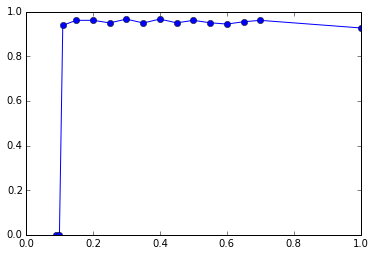

In [80]:
plt.plot(sigmas,wineMeansN,'bo-')

In [ ]:
sigmas = [10,11,12,15,20,21,22,23,24,25,26,27,28,29,30,35]
wdbcX,wdbcY = loadWdbc()
wdbcMeans = runSigma(wdbcX,wdbcY,sigmas)

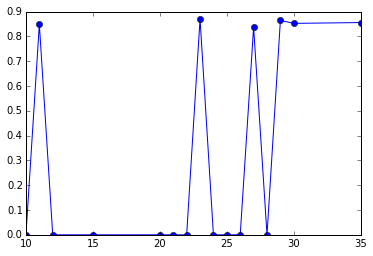

In [26]:
plt.plot(sigmas,wdbcMeans,'bo-')

In [ ]:
sigmas = [1,2,5,10,15,20,24,30,35]
uspsX,uspsY = loadUsps()
uspsMeans = runSigma(uspsX,uspsY,sigmas)

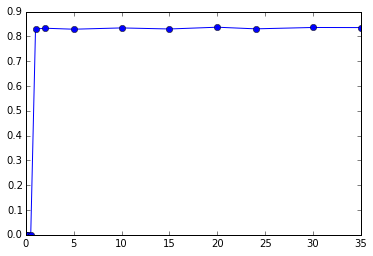

In [30]:
plt.plot(sigmas,uspsMeans,'bo-')

In [36]:
sigmas = [.1,.2,.5,1,2,5,10,15,20,24,30,35]
waveformX,waveformY= loadWaveform()
waveformMeans = runSigma(waveformX,waveformY,sigmas)

Factor is exactly singular
Factor is exactly singular
Factor is exactly singular
Factor is exactly singular
ARPACK error -1: No convergence (50301 iterations, 6/7 eigenvectors converged)


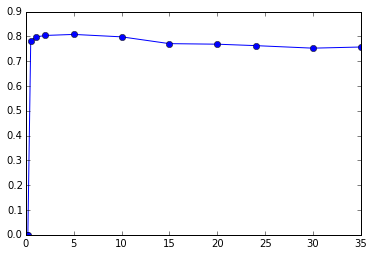

In [37]:
plt.plot(sigmas,waveformMeans,'bo-')

In [39]:
sigmas = [0.01,.02,.05,.1,.2,.5,1,2,5,10,15,20,24,30,35]
sonarX,sonarY= loadSonar()
sonarMeans = runSigma(sonarX,sonarY,sigmas)

Factor is exactly singular
Factor is exactly singular
ARPACK error -1: No convergence (2381 iterations, 1/7 eigenvectors converged)
ARPACK error -1: No convergence (2381 iterations, 0/7 eigenvectors converged) [ARPACK error -14: DNAUPD  did not find any eigenvalues to sufficient accuracy.]


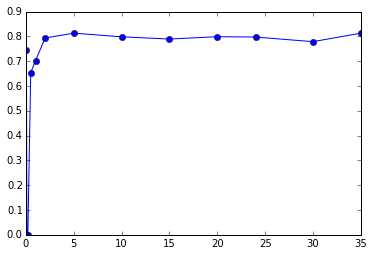

In [41]:
plt.plot(sigmas,sonarMeans,'bo-')

In [53]:
sigmas = [0.01,.02,.05,.1,.2,.5,1,2,5,10,15,20,24,30,35]
moonX,moonY, tmp = generateTwoParabola()
moonMeans = runSigma(moonX,moonY,sigmas)

Factor is exactly singular
Factor is exactly singular
Factor is exactly singular
ARPACK error -1: No convergence (8301 iterations, 6/7 eigenvectors converged)
ARPACK error -1: No convergence (8301 iterations, 0/7 eigenvectors converged) [ARPACK error -14: DNAUPD  did not find any eigenvalues to sufficient accuracy.]


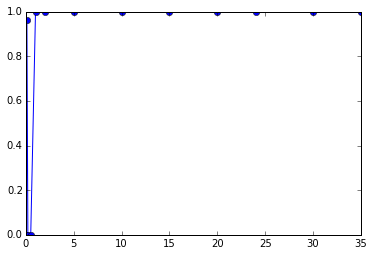

In [54]:
plt.plot(sigmas,moonMeans,'bo-')

In [56]:
sigmas = [0.01,.02,.05,.1,.2,.5,1,2,5,10,15,20,24,30,35]
diskX,diskY,tmp = generateTwoDisks()
diskMeans = runSigma(diskX,diskY,sigmas)

Factor is exactly singular
Factor is exactly singular
Factor is exactly singular
Factor is exactly singular
Factor is exactly singular


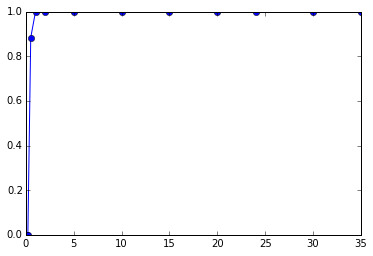

In [57]:
plt.plot(sigmas,diskMeans,'bo-')

In [60]:
sigmas = [0.01,.02,.05,.1,.2,.5,1,2,5,10,15,20,24,30,35]
xorX,xorY,tmp = generateXOR()
xorMeans = runSigma(xorX,xorY,sigmas)

Factor is exactly singular
Factor is exactly singular
ARPACK error -1: No convergence (4301 iterations, 0/7 eigenvectors converged) [ARPACK error -14: DNAUPD  did not find any eigenvalues to sufficient accuracy.]


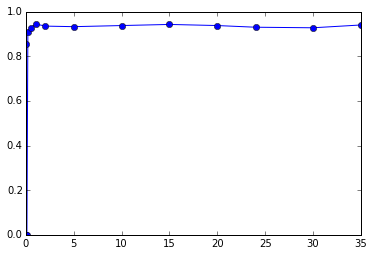

In [61]:
plt.plot(sigmas,xorMeans,'bo-')

In [72]:
sigmas = [0.01,.02,.05,.1,.2,.5,1,2,5,10]
concentricX,concentricY,tmp = generateConcentric()
concentricMeans = runSigma(concentricX,concentricY,sigmas)
plt.plot(sigmas,concentricMeans,'bo-')

Factor is exactly singular
ARPACK error -1: No convergence (3431 iterations, 0/7 eigenvectors converged) [ARPACK error -14: DNAUPD  did not find any eigenvalues to sufficient accuracy.]
ARPACK error -1: No convergence (3431 iterations, 6/7 eigenvectors converged)
ARPACK error -1: No convergence (3431 iterations, 6/7 eigenvectors converged)
ARPACK error -1: No convergence (3431 iterations, 6/7 eigenvectors converged)
ARPACK error -1: No convergence (3431 iterations, 6/7 eigenvectors converged)
ARPACK error -1: No convergence (3431 iterations, 6/7 eigenvectors converged)


In [40]:
import numpy as np
from sklearn import mixture
np.random.seed(1)
g = mixture.GMM(n_components=2)
# Generate random observations with two modes centered on 0
# and 10 to use for training.
obs = np.concatenate((np.random.randn(100, 1),
                      10 + np.random.randn(300, 1)))
g.fit(obs) 


np.round(g.weights_, 2)

np.round(g.means_, 2)


np.round(g.covars_, 2) 


g.predict([[0], [2], [9], [10]]) 

array([1, 1, 0, 0], dtype=int64)

In [ ]:
iris = datasets.load_iris()

# Break up the dataset into non-overlapping training (75%) and testing
# (25%) sets.
skf = StratifiedKFold(iris.target, n_folds=4)
# Only take the first fold.
train_index, test_index = next(iter(skf))


X_train = iris.data[train_index]
y_train = iris.target[train_index]
X_test = iris.data[test_index]
y_test = iris.target[test_index]
n_classes = len(np.unique(y_train))


In [41]:
from sklearn import datasets
from sklearn.multiclass import OneVsOneClassifier
from sklearn.svm import LinearSVC
iris = datasets.load_iris()
X, y = iris.data, iris.target
OneVsOneClassifier(LinearSVC(random_state=0)).fit(X, y).predict(X)

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 2, 1, 2, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
       2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
       2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2])

In [44]:
from sklearn import datasets
from sklearn.multiclass import OneVsOneClassifier
from sklearn.svm import LinearSVC
iris = datasets.load_iris()
wineX, wineY = loadWineNorm()
predict = OneVsOneClassifier(LinearSVC(random_state=0)).fit(wineX, wineY).predict(wineX)
np.sum(predict==wineY)*1.0/predict.shape[0]


0.9943820224719101

<h2 style="color:red">-------------------- NMI -------------------</h2>

In [77]:
def unsupervised10FoldNMI(X,y,numP,sigma):
#     numP = 40
    numS = X.shape[0]
    numClass = len(np.unique(sorted(y)))
    centers = Prototyping(X,numP)
    acc = []
    kf = KFold(numS,n_folds=10,shuffle=True)
    i = 0
    for train_index,test_index in kf:
        W,D,L = bipartiteUnsupervised(X,centers,sigma)
        vals, vecs = sps.linalg.eigs(L, M=D, k=7)
        vals = vals.real
        vecs = vecs.real[:numS]
        yTrain = y[train_index]
        yTest = y[test_index]
        newRepTrain = vecs[:,1:7][train_index]
        newRepTest = vecs[:,1:7][test_index]

        kmeans = KMeans(init='k-means++',n_clusters=numClass)
        kmeans.fit(newRepTest)
        acc.append(NMI(kmeans.labels_,yTest))
        
        i += 1
    return np.mean(acc),np.std(acc)

In [78]:
def runSigmaNMI(X,Y,sigmas):
    Means = np.zeros(len(sigmas))
    Stds = np.zeros(len(sigmas))
    numP = 30
    idx = 0
    for sigma in sigmas:
#         print '--------------------------------------- sigma: ',sigma
        try:
            Means[idx],Stds[idx] = unsupervised10FoldNMI(X,Y,numP,sigma)
        except Exception as e:
            print e
        idx += 1
#         Means[idx] = supervised10FoldRepresentation(wineX,wineY,1)
    return Means,Stds

In [79]:
def run10FoldNMI(X,y,sigmas):
    result = []
    resultStd = []
    for i in xrange(10):
        Means,Stds = runSigma(X,y,sigmas,nclf)
        result.append(Means.max())
        resultStd.append(Stds[Means.argmax()])
        print i , Means.max(),Stds[Means.argmax()]
        print 'sigma:', sigmas[Means.argmax()]
    return result,resultStd

In [80]:
sigmas = [.05,.07,.08,.09,.1,.11,.12,.13,.15,.2,.25]
wineX,wineY = loadWineNorm()

wineResult,wineResultStd = run10FoldNMI(wineX,wineY,sigmas)

ARPACK error -1: No convergence (2081 iterations, 0/7 eigenvectors converged) [ARPACK error -14: DNAUPD  did not find any eigenvalues to sufficient accuracy.]
ARPACK error -1: No convergence (2081 iterations, 0/7 eigenvectors converged) [ARPACK error -14: DNAUPD  did not find any eigenvalues to sufficient accuracy.]
ARPACK error -1: No convergence (2081 iterations, 0/7 eigenvectors converged) [ARPACK error -14: DNAUPD  did not find any eigenvalues to sufficient accuracy.]
ARPACK error -1: No convergence (2081 iterations, 0/7 eigenvectors converged) [ARPACK error -14: DNAUPD  did not find any eigenvalues to sufficient accuracy.]
ARPACK error -1: No convergence (2081 iterations, 4/7 eigenvectors converged)
ARPACK error -1: No convergence (2081 iterations, 0/7 eigenvectors converged) [ARPACK error -14: DNAUPD  did not find any eigenvalues to sufficient accuracy.]
ARPACK error -1: No convergence (2081 iterations, 0/7 eigenvectors converged) [ARPACK error -14: DNAUPD  did not find any eigen

In [81]:
sigmas = [.001,.01,.02,.05,.1,.2,.3,.4,.5,.6,.7,.8,.9,1]
irisX,irisY = loadIris()
irisResult,irisResultStd = run10FoldNMI(irisX,irisY,sigmas)

Factor is exactly singular
Factor is exactly singular
ARPACK error -1: No convergence (1801 iterations, 0/7 eigenvectors converged) [ARPACK error -14: DNAUPD  did not find any eigenvalues to sufficient accuracy.]
ARPACK error -1: No convergence (1801 iterations, 0/7 eigenvectors converged) [ARPACK error -14: DNAUPD  did not find any eigenvalues to sufficient accuracy.]
0 0.913333333333 0.0669991708075
sigma: 0.3
Factor is exactly singular
Factor is exactly singular
ARPACK error -1: No convergence (1801 iterations, 0/7 eigenvectors converged) [ARPACK error -14: DNAUPD  did not find any eigenvalues to sufficient accuracy.]
ARPACK error -1: No convergence (1801 iterations, 1/7 eigenvectors converged)
1 0.906666666667 0.0679869268479
sigma: 0.3
Factor is exactly singular
Factor is exactly singular
ARPACK error -1: No convergence (1801 iterations, 0/7 eigenvectors converged) [ARPACK error -14: DNAUPD  did not find any eigenvalues to sufficient accuracy.]
ARPACK error -1: No convergence (180

In [82]:
sigmas = [.5,.8,1,2,3,4,5,8,10,15,20,25,30,35]
glassX,glassY = loadGlass()
glassResult,glassResultStd = run10FoldNMI(glassX,glassY,sigmas)

ARPACK error -1: No convergence (2441 iterations, 0/7 eigenvectors converged) [ARPACK error -14: DNAUPD  did not find any eigenvalues to sufficient accuracy.]
0 0.360822510823 0.0883374145535
sigma: 8
ARPACK error -1: No convergence (2441 iterations, 0/7 eigenvectors converged) [ARPACK error -14: DNAUPD  did not find any eigenvalues to sufficient accuracy.]
1 0.377705627706 0.134958923042
sigma: 3
ARPACK error -1: No convergence (2441 iterations, 0/7 eigenvectors converged) [ARPACK error -14: DNAUPD  did not find any eigenvalues to sufficient accuracy.]
2 0.354761904762 0.0673605453987
sigma: 8
ARPACK error -1: No convergence (2441 iterations, 0/7 eigenvectors converged) [ARPACK error -14: DNAUPD  did not find any eigenvalues to sufficient accuracy.]
3 0.355194805195 0.0926470139851
sigma: 20
ARPACK error -1: No convergence (2441 iterations, 0/7 eigenvectors converged) [ARPACK error -14: DNAUPD  did not find any eigenvalues to sufficient accuracy.]
4 0.360822510823 0.077130721858
sigma

In [83]:
sigmas = [10,11,12,15,20,21,22,23,24,25,26,27,28,29,30,35]
wdbcX,wdbcY = loadWdbc()
wdbcResult,wdbcResultStd = run10FoldNMI(wdbcX,wdbcY,sigmas)

ARPACK error -1: No convergence (5991 iterations, 6/7 eigenvectors converged)
ARPACK error -1: No convergence (5991 iterations, 5/7 eigenvectors converged)
ARPACK error -1: No convergence (5991 iterations, 0/7 eigenvectors converged) [ARPACK error -14: DNAUPD  did not find any eigenvalues to sufficient accuracy.]
ARPACK error -1: No convergence (5991 iterations, 6/7 eigenvectors converged)
ARPACK error -1: No convergence (5991 iterations, 0/7 eigenvectors converged) [ARPACK error -14: DNAUPD  did not find any eigenvalues to sufficient accuracy.]
ARPACK error -1: No convergence (5991 iterations, 5/7 eigenvectors converged)
ARPACK error -1: No convergence (5991 iterations, 0/7 eigenvectors converged) [ARPACK error -14: DNAUPD  did not find any eigenvalues to sufficient accuracy.]
ARPACK error -1: No convergence (5991 iterations, 5/7 eigenvectors converged)
ARPACK error -1: No convergence (5991 iterations, 5/7 eigenvectors converged)
0 0.834868421053 0.084832146924
sigma: 27
ARPACK error 

In [84]:
sigmas = [1,2,5,10,15,20,24,30,35]
moonX,moonY, tmp = generateTwoParabola()
moonResult,moonResultStd = run10FoldNMI(moonX,moonY,sigmas)

0 0.935 0.0334477204006
sigma: 5
1 0.94 0.0192028643697
sigma: 5
2 0.9425 0.1725
sigma: 2
3 0.94375 0.0218303114957
sigma: 5
4 0.93875 0.01625
sigma: 5
5 0.94 0.0229128784748
sigma: 5
6 1.0 0.0
sigma: 1
7 0.9375 0.0201556443707
sigma: 5
8 0.94 0.02
sigma: 5
9 1.0 0.0
sigma: 1


In [85]:
sigmas = [.1,.2,.3,.4,.5,.6,.7,.8,.9,1,2,5]
xorX,xorY,tmp = generateXOR()
xorResult,xorResultStd = run10FoldNMI(xorX,xorY,sigmas)

ARPACK error -1: No convergence (4301 iterations, 0/7 eigenvectors converged) [ARPACK error -14: DNAUPD  did not find any eigenvalues to sufficient accuracy.]
0 0.965 0.0357071421427
sigma: 0.9
ARPACK error -1: No convergence (4301 iterations, 0/7 eigenvectors converged) [ARPACK error -14: DNAUPD  did not find any eigenvalues to sufficient accuracy.]
1 0.9625 0.0340036762718
sigma: 0.6
ARPACK error -1: No convergence (4301 iterations, 0/7 eigenvectors converged) [ARPACK error -14: DNAUPD  did not find any eigenvalues to sufficient accuracy.]
2 0.965 0.0165831239518
sigma: 0.7
ARPACK error -1: No convergence (4301 iterations, 0/7 eigenvectors converged) [ARPACK error -14: DNAUPD  did not find any eigenvalues to sufficient accuracy.]
3 0.965 0.03
sigma: 0.9
ARPACK error -1: No convergence (4301 iterations, 3/7 eigenvectors converged)
4 0.965 0.0165831239518
sigma: 0.3
ARPACK error -1: No convergence (4301 iterations, 0/7 eigenvectors converged) [ARPACK error -14: DNAUPD  did not find any

In [86]:
import scipy.io as io
def generateConcentric():
    concentric = io.loadmat("Concentric_rings.mat")
    X = concentric['X'][:,[0,1]]
    Y = concentric['Y'][:,0]
    Y = (Y==1)
    return X,Y,"Concentric"

In [87]:
sigmas = [.4,.5,.7,.8,.9,1,1.1,1.2,1.3,1.5]
concentricX,concentricY,tmp = generateConcentric()
concentricResult,concentricResultStd = run10FoldNMI(concentricX,concentricY,sigmas)

0 0.776209677419 0.108210924834
sigma: 0.4
1 0.779838709677 0.0622657551033
sigma: 0.4
2 0.776411290323 0.096978530912
sigma: 0.4
3 0.779435483871 0.0703189852773
sigma: 0.4
4 0.786391129032 0.0951160554906
sigma: 0.4
5 0.779737903226 0.0675707833333
sigma: 0.4
6 0.786088709677 0.0949239282753
sigma: 0.4
7 0.776008064516 0.0958762100768
sigma: 0.4
8 0.779939516129 0.0582780745931
sigma: 0.4
9 0.770362903226 0.0683060231544
sigma: 0.4


In [88]:
sigmas = [.2,.5,.6,.7,.8,.9,1,1.1,1.2,1.5,2,2.5,3,4,5,7,8,10]
waveformX,waveformY= loadWaveform()
waveformResult,waveformResultStd = run10FoldNMI(waveformX,waveformY,sigmas)

ARPACK error -1: No convergence (50301 iterations, 2/7 eigenvectors converged)
0 0.864 0.0135055544129
sigma: 3
ARPACK error -1: No convergence (50301 iterations, 1/7 eigenvectors converged)
1 0.8678 0.0074
sigma: 3
ARPACK error -1: No convergence (50301 iterations, 1/7 eigenvectors converged)
2 0.869 0.0138057958843
sigma: 3
ARPACK error -1: No convergence (50301 iterations, 3/7 eigenvectors converged)
3 0.8654 0.0159511755053
sigma: 3
ARPACK error -1: No convergence (50301 iterations, 3/7 eigenvectors converged)
4 0.866 0.0167332005307
sigma: 3
ARPACK error -1: No convergence (50301 iterations, 1/7 eigenvectors converged)
5 0.863 0.0140071410359
sigma: 4
ARPACK error -1: No convergence (50301 iterations, 6/7 eigenvectors converged)
6 0.8648 0.0161294761229
sigma: 3
ARPACK error -1: No convergence (50301 iterations, 3/7 eigenvectors converged)
7 0.8648 0.0119733036377
sigma: 3
ARPACK error -1: No convergence (50301 iterations, 2/7 eigenvectors converged)
8 0.8668 0.0114262854857
sigma

In [89]:
sigmas = [.5,1,1.5,1.7,1.8,1.9,2,2.1,2.2,2.3,2.5,3,4,5,10]
uspsX,uspsY = loadUsps()
uspsResult,uspsResultStd = run10FoldNMI(uspsX,uspsY,sigmas)

ARPACK error -1: No convergence (73211 iterations, 6/7 eigenvectors converged)
0 0.824578987917 0.0122956361712
sigma: 1.8
ARPACK error -1: No convergence (73211 iterations, 5/7 eigenvectors converged)
1 0.817306311893 0.0167006630821
sigma: 1.7
ARPACK error -1: No convergence (73211 iterations, 5/7 eigenvectors converged)
2 0.813193152564 0.0135089561688
sigma: 1.9
ARPACK error -1: No convergence (73211 iterations, 5/7 eigenvectors converged)
3 0.817856699927 0.0144737382234
sigma: 1.9
ARPACK error -1: No convergence (73211 iterations, 5/7 eigenvectors converged)
4 0.829241595731 0.0141386302363
sigma: 1.8
ARPACK error -1: No convergence (73211 iterations, 3/7 eigenvectors converged)
ARPACK error -1: No convergence (73211 iterations, 0/7 eigenvectors converged) [ARPACK error -14: DNAUPD  did not find any eigenvalues to sufficient accuracy.]
5 0.806885205855 0.0245214252829
sigma: 1.7
6 0.830203318488 0.0172549539339
sigma: 1.8
ARPACK error -1: No convergence (73211 iterations, 6/7 eig